# Face Generation

In this project, you'll define and train a DCGAN on a dataset of faces. Your goal is to get a generator network to generate *new* images of faces that look as realistic as possible!

The project will be broken down into a series of tasks from **loading in data to defining and training adversarial networks**. At the end of the notebook, you'll be able to visualize the results of your trained Generator to see how it performs; your generated samples should look like fairly realistic faces with small amounts of noise.

### Get the Data

You'll be using the [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) to train your adversarial networks.

This dataset is more complex than the number datasets (like MNIST or SVHN) you've been working with, and so, you should prepare to define deeper networks and train them for a longer time to get good results. It is suggested that you utilize a GPU for training.

### Pre-processed Data

Since the project's main focus is on building the GANs, we've done *some* of the pre-processing for you. Each of the CelebA images has been cropped to remove parts of the image that don't include a face, then resized down to 64x64x3 NumPy images. Some sample data is show below.

<img src='assets/processed_face_data.png' width=60% />

> If you are working locally, you can download this data [by clicking here](https://s3.amazonaws.com/video.udacity-data.com/topher/2018/November/5be7eb6f_processed-celeba-small/processed-celeba-small.zip)

This is a zip file that you'll need to extract in the home directory of this notebook for further loading and processing. After extracting the data, you should be left with a directory of data `processed_celeba_small/`

In [88]:
# can comment out after executing
# !unzip processed-celeba-small.zip

In [89]:
data_dir = 'processed_celeba_small/'

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import pickle as pkl
import matplotlib.pyplot as plt
import numpy as np
import problem_unittests as tests
#import helper

%matplotlib inline

## Visualize the CelebA Data

The [CelebA](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations. Since you're going to be generating faces, you won't need the annotations, you'll only need the images. Note that these are color images with [3 color channels (RGB)](https://en.wikipedia.org/wiki/Channel_(digital_image)#RGB_Images) each.

### Pre-process and Load the Data

Since the project's main focus is on building the GANs, we've done *some* of the pre-processing for you. Each of the CelebA images has been cropped to remove parts of the image that don't include a face, then resized down to 64x64x3 NumPy images. This *pre-processed* dataset is a smaller subset of the very large CelebA data.

> There are a few other steps that you'll need to **transform** this data and create a **DataLoader**.

#### Exercise: Complete the following `get_dataloader` function, such that it satisfies these requirements:

* Your images should be square, Tensor images of size `image_size x image_size` in the x and y dimension.
* Your function should return a DataLoader that shuffles and batches these Tensor images.

#### ImageFolder

To create a dataset given a directory of images, it's recommended that you use PyTorch's [ImageFolder](https://pytorch.org/docs/stable/torchvision/datasets.html#imagefolder) wrapper, with a root directory `processed_celeba_small/` and data transformation passed in.

In [90]:
# necessary imports
import torch
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import DataLoader

In [91]:
def get_dataloader(batch_size, image_size, data_dir='processed_celeba_small/'):
    """
    Batch the neural network data using DataLoader
    :param batch_size: The size of each batch; the number of images in a batch
    :param img_size: The square size of the image data (x, y)
    :param data_dir: Directory where image data is located
    :return: DataLoader with batched data
    """
    
    # TODO: Implement function and return a dataloader
    transform = transforms.Compose([transforms.Resize(image_size),
                                    transforms.ToTensor()])
    
    # get directories
    image_path = './' + data_dir + 'celeba/'

    # define datasets using ImageFolder
    im_dataset = datasets.ImageFolder(image_path, transform = transform)
    
    # create and return DataLoaders
    img_loader = DataLoader(im_dataset, batch_size = batch_size, shuffle=True)
    
    return img_loader


## Create a DataLoader

#### Exercise: Create a DataLoader `celeba_train_loader` with appropriate hyperparameters.

Call the above function and create a dataloader to view images. 
* You can decide on any reasonable `batch_size` parameter
* Your `image_size` **must be** `32`. Resizing the data to a smaller size will make for faster training, while still creating convincing images of faces!

In [92]:
# Define function hyperparameters
batch_size = 32
img_size = 32

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# Call your function and get a dataloader
celeba_train_loader = get_dataloader(batch_size, img_size)


Next, you can view some images! You should seen square images of somewhat-centered faces.

Note: You'll need to convert the Tensor images into a NumPy type and transpose the dimensions to correctly display an image, suggested `imshow` code is below, but it may not be perfect.

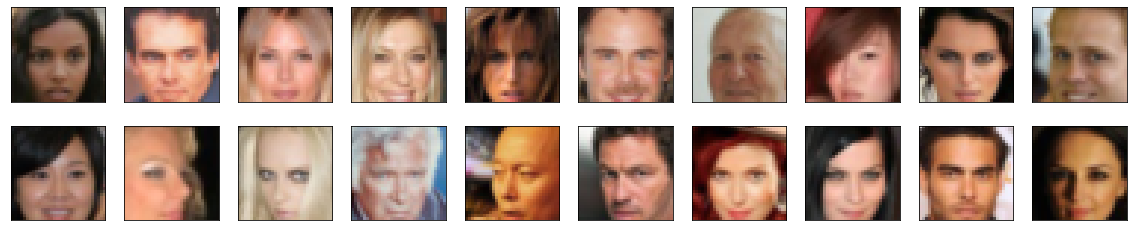

In [93]:
# helper display function
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# obtain one batch of training images
dataiter = iter(celeba_train_loader)
images, _ = dataiter.next() # _ for no labels

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(20, 4))
plot_size=20
for idx in np.arange(plot_size):
    ax = fig.add_subplot(2, plot_size/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])

#### Exercise: Pre-process your image data and scale it to a pixel range of -1 to 1

You need to do a bit of pre-processing; you know that the output of a `tanh` activated generator will contain pixel values in a range from -1 to 1, and so, we need to rescale our training images to a range of -1 to 1. (Right now, they are in a range from 0-1.)

In [94]:
# TODO: Complete the scale function
def scale(x, feature_range=(-1, 1)):
    ''' Scale takes in an image x and returns that image, scaled
       with a feature_range of pixel values from -1 to 1. 
       This function assumes that the input x is already scaled from 0-1.'''
    # assume x is scaled to (0, 1)
    # scale to feature_range and return scaled x
    min, max = feature_range
    x = x * (max - min) + min
    
    return x


In [95]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# check scaled range
# should be close to -1 to 1
img = images[0]
scaled_img = scale(img)

print('Min: ', scaled_img.min())
print('Max: ', scaled_img.max())

Min:  tensor(-0.9686)
Max:  tensor(0.5843)


---
# Define the Model

A GAN is comprised of two adversarial networks, a discriminator and a generator.

## Discriminator

Your first task will be to define the discriminator. This is a convolutional classifier like you've built before, only without any maxpooling layers. To deal with this complex data, it's suggested you use a deep network with **normalization**. You are also allowed to create any helper functions that may be useful.

#### Exercise: Complete the Discriminator class
* The inputs to the discriminator are 32x32x3 tensor images
* The output should be a single value that will indicate whether a given image is real or fake


In [96]:
import torch.nn as nn
import torch.nn.functional as F

### Convolutional Helper Function

In [97]:
def conv(in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm=True):
    """
    Helper function derived from the GAN exercises that we worked on during this module
    """
    
    layers = []
    conv_layer = nn.Conv2d(in_channels = in_channels, out_channels = out_channels, kernel_size = kernel_size,
                           stride = stride, padding = padding, bias=False)
    
    layers.append(conv_layer)
    
    if batch_norm:
        layers.append(nn.BatchNorm2d(out_channels))
        
    return nn.Sequential(*layers)    

In [98]:
class Discriminator(nn.Module):

    def __init__(self, conv_dim):
        """
        Initialize the Discriminator Module
        :param conv_dim: The depth of the first convolutional layer
        """
        super(Discriminator, self).__init__()
        self.conv_dim = conv_dim

        # complete init function
        self.conv1 = conv(3, conv_dim, 4, batch_norm=False) # 3x32x32 input, output dimx16x16
        self.conv2 = conv(conv_dim, conv_dim*2, 4) # dim*2x8x8
        self.conv3 = conv(conv_dim*2, conv_dim*4, 4) # dim*4x4x4
        # self.conv3 = conv(conv_dim*2, 1, 4, stride=1, batch_norm=False) # dim*4x4x4
        self.conv4 = conv(conv_dim*4, conv_dim*8, 4, batch_norm=False)
        
        # classification layer
        self.fc = nn.Linear(conv_dim*8*2*2, 1)
        

    def forward(self, x):
        """
        Forward propagation of the neural network
        :param x: The input to the neural network     
        :return: Discriminator logits; the output of the neural network
        """
        # define feedforward behavior
        x = F.leaky_relu(self.conv1(x), 0.2)
        x = F.leaky_relu(self.conv2(x), 0.2)
        x = F.leaky_relu(self.conv3(x), 0.2)
        x = F.leaky_relu(self.conv4(x), 0.2)
        #x = self.conv4(x)
        x = x.view(-1, self.conv_dim*8*2*2)
        x = self.fc(x)
        return x


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(Discriminator)

Tests Passed


## Generator

The generator should upsample an input and generate a *new* image of the same size as our training data `32x32x3`. This should be mostly transpose convolutional layers with normalization applied to the outputs.

#### Exercise: Complete the Generator class
* The inputs to the generator are vectors of some length `z_size`
* The output should be a image of shape `32x32x3`

In [99]:
def deconv(in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm=True):
    """
    deconv function derived from from DCGAN exercise
    """
    layers = []
    
    deconv_layer = nn.ConvTranspose2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size,
                                      stride=stride, padding=padding, bias=False)
    
    layers.append(deconv_layer)
    if batch_norm:
        layers.append(nn.BatchNorm2d(out_channels))
    
    return nn.Sequential(*layers)

In [100]:
class Generator(nn.Module):
    
    def __init__(self, z_size, conv_dim):
        """
        Initialize the Generator Module
        :param z_size: The length of the input latent vector, z
        :param conv_dim: The depth of the inputs to the *last* transpose convolutional layer
        """
        super(Generator, self).__init__()
        self.z_size = z_size
        self.conv_dim = conv_dim

        # complete init function
        self.fc1 = nn.Linear(z_size, 4*4*4*conv_dim)
        self.tconv1 = deconv(4*conv_dim, 2*conv_dim, 4)
        self.tconv2 = deconv(2*conv_dim, conv_dim, 4)
        self.tconv3 = deconv(conv_dim, 3, 4, batch_norm=False)
        

    def forward(self, x):
        """
        Forward propagation of the neural network
        :param x: The input to the neural network     
        :return: A 32x32x3 Tensor image as output
        """
        # define feedforward behavior
        x = self.fc1(x)
        x = x.view(-1, 4*self.conv_dim, 4, 4)
        
        x = F.leaky_relu(self.tconv1(x))
        x = F.leaky_relu(self.tconv2(x))
        x = torch.tanh(self.tconv3(x))
        return x

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(Generator)

Tests Passed


## Initialize the weights of your networks

To help your models converge, you should initialize the weights of the convolutional and linear layers in your model. From reading the [original DCGAN paper](https://arxiv.org/pdf/1511.06434.pdf), they say:
> All weights were initialized from a zero-centered Normal distribution with standard deviation 0.02.

So, your next task will be to define a weight initialization function that does just this!

You can refer back to the lesson on weight initialization or even consult existing model code, such as that from [the `networks.py` file in CycleGAN Github repository](https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix/blob/master/models/networks.py) to help you complete this function.

#### Exercise: Complete the weight initialization function

* This should initialize only **convolutional** and **linear** layers
* Initialize the weights to a normal distribution, centered around 0, with a standard deviation of 0.02.
* The bias terms, if they exist, may be left alone or set to 0.

In [101]:
def weights_init_normal(m):
    """
    Applies initial weights to certain layers in a model .
    The weights are taken from a normal distribution 
    with mean = 0, std dev = 0.02.
    :param m: A module or layer in a network    
    """
    # classname will be something like:
    # `Conv`, `BatchNorm2d`, `Linear`, etc.
    classname = m.__class__.__name__
    
    # TODO: Apply initial weights to convolutional and linear layers
    # code from mentor help in the Knowledge base: https://knowledge.udacity.com/questions/242873
    if hasattr(m, 'weight') and (classname.find('Conv') != -1 or classname.find('Linear') != -1):
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    

## Build complete network

Define your models' hyperparameters and instantiate the discriminator and generator from the classes defined above. Make sure you've passed in the correct input arguments.

In [102]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
def build_network(d_conv_dim, g_conv_dim, z_size):
    # define discriminator and generator
    D = Discriminator(d_conv_dim)
    G = Generator(z_size=z_size, conv_dim=g_conv_dim)

    # initialize model weights
    D.apply(weights_init_normal)
    G.apply(weights_init_normal)

    print(D)
    print()
    print(G)
    
    return D, G


#### Exercise: Define model hyperparameters

In [103]:
# Define model hyperparams
d_conv_dim = 128
g_conv_dim = 128
z_size = 100

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
D, G = build_network(d_conv_dim, g_conv_dim, z_size)

Discriminator(
  (conv1): Sequential(
    (0): Conv2d(3, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  )
  (conv2): Sequential(
    (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): Sequential(
    (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv4): Sequential(
    (0): Conv2d(512, 1024, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  )
  (fc): Linear(in_features=4096, out_features=1, bias=True)
)

Generator(
  (fc1): Linear(in_features=100, out_features=8192, bias=True)
  (tconv1): Sequential(
    (0): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats

### Training on GPU

Check if you can train on GPU. Here, we'll set this as a boolean variable `train_on_gpu`. Later, you'll be responsible for making sure that 
>* Models,
* Model inputs, and
* Loss function arguments

Are moved to GPU, where appropriate.

In [104]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import torch

# Check for a GPU
train_on_gpu = torch.cuda.is_available()
if not train_on_gpu:
    print('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Training on GPU!')

Training on GPU!


---
## Discriminator and Generator Losses

Now we need to calculate the losses for both types of adversarial networks.

### Discriminator Losses

> * For the discriminator, the total loss is the sum of the losses for real and fake images, `d_loss = d_real_loss + d_fake_loss`. 
* Remember that we want the discriminator to output 1 for real images and 0 for fake images, so we need to set up the losses to reflect that.


### Generator Loss

The generator loss will look similar only with flipped labels. The generator's goal is to get the discriminator to *think* its generated images are *real*.

#### Exercise: Complete real and fake loss functions

**You may choose to use either cross entropy or a least squares error loss to complete the following `real_loss` and `fake_loss` functions.**

In [105]:
def real_loss(D_out, smooth=False):
    '''Calculates how close discriminator outputs are to being real.
       param, D_out: discriminator logits
       return: real loss'''
    # need a sigmoid on the discriminator
    # use BCE loss
    
    batch_size = D_out.size(0)
    
    if smooth:
        labels = torch.ones(batch_size) * 0.9
    else:
        labels = torch.ones(batch_size)
    
    if train_on_gpu:
        labels = labels.cuda()
    
    #BCE with logits loss
    criterion = nn.BCEWithLogitsLoss()
    
    loss = criterion(D_out.squeeze(), labels)
    return loss

def fake_loss(D_out):
    '''Calculates how close discriminator outputs are to being fake.
       param, D_out: discriminator logits
       return: fake loss'''
    batch_size = D_out.size(0)
    
    labels = torch.zeros(batch_size)
    
    if train_on_gpu:
        labels = labels.cuda()
    
    #BCE with logits loss
    criterion = nn.BCEWithLogitsLoss()
    
    loss = criterion(D_out.squeeze(), labels)
    return loss

## Optimizers

#### Exercise: Define optimizers for your Discriminator (D) and Generator (G)

Define optimizers for your models with appropriate hyperparameters.

In [106]:
import torch.optim as optim

# Create optimizers for the discriminator D and generator G
lr = 0.0002
beta1=0.5
beta2=0.999 # default value

d_optimizer = optim.Adam(D.parameters(), lr, betas=[beta1, beta2])
g_optimizer = optim.Adam(G.parameters(), lr, betas=[beta1, beta2])

---
## Training

Training will involve alternating between training the discriminator and the generator. You'll use your functions `real_loss` and `fake_loss` to help you calculate the discriminator losses.

* You should train the discriminator by alternating on real and fake images
* Then the generator, which tries to trick the discriminator and should have an opposing loss function


#### Saving Samples

You've been given some code to print out some loss statistics and save some generated "fake" samples.

#### Exercise: Complete the training function

Keep in mind that, if you've moved your models to GPU, you'll also have to move any model inputs to GPU.

In [107]:
def train(D, G, n_epochs, print_every=50):
    '''Trains adversarial networks for some number of epochs
       param, D: the discriminator network
       param, G: the generator network
       param, n_epochs: number of epochs to train for
       param, print_every: when to print and record the models' losses
       return: D and G losses'''
    
    # move models to GPU
    if train_on_gpu:
        D.cuda()
        G.cuda()

    # keep track of loss and generated, "fake" samples
    samples = []
    losses = []

    # Get some fixed data for sampling. These are images that are held
    # constant throughout training, and allow us to inspect the model's performance
    sample_size=16
    fixed_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
    fixed_z = torch.from_numpy(fixed_z).float()
    # move z to GPU if available
    if train_on_gpu:
        fixed_z = fixed_z.cuda()

    # epoch training loop
    for epoch in range(n_epochs):

        # batch training loop
        for batch_i, (real_images, _) in enumerate(celeba_train_loader):

            batch_size = real_images.size(0)
            real_images = scale(real_images)
            
            if train_on_gpu:
                real_images = real_images.cuda()

            # ===============================================
            #         YOUR CODE HERE: TRAIN THE NETWORKS
            # ===============================================
            
            # 1. Train the discriminator on real and fake images
            # Zero out gradients
            d_optimizer.zero_grad()
            # compute discriminator losses on real images
            d_real = D(real_images)
            d_real_loss = real_loss(d_real, smooth=True)
            
            # create fake images
            z = np.random.uniform(-1, 1, size=(batch_size, z_size))
            z = torch.from_numpy(z).float()
            
            if train_on_gpu:
                z = z.cuda()
            fake_images = G(z)
            
            d_fake = D(fake_images)
            d_fake_loss = fake_loss(d_fake)
            
            # add up losses and perform backprop
            d_loss = d_real_loss + d_fake_loss
            d_loss.backward()
            d_optimizer.step()
            

            # 2. Train the generator with an adversarial loss
            # zero gradients
            g_optimizer.zero_grad()
            
            # train with fake images and flipped labels
            # generate fake images
            z = np.random.uniform(-1, 1, size=(batch_size, z_size))
            z = torch.from_numpy(z).float()
            
            if train_on_gpu:
                z = z.cuda()
            fake_images = G(z)
            
            # compute the discriminator losses on fake images using flipped labels
            d_fake = D(fake_images)
            g_loss = real_loss(d_fake)
            g_loss.backward()
            g_optimizer.step()
            
            
            # ===============================================
            #              END OF YOUR CODE
            # ===============================================

            # Print some loss stats
            if batch_i % print_every == 0:
                # append discriminator loss and generator loss
                losses.append((d_loss.item(), g_loss.item()))
                # print discriminator and generator loss
                print('Epoch [{:5d}/{:5d}] | d_loss: {:6.4f} | g_loss: {:6.4f}'.format(
                        epoch+1, n_epochs, d_loss.item(), g_loss.item()))


        ## AFTER EACH EPOCH##    
        # this code assumes your generator is named G, feel free to change the name
        # generate and save sample, fake images
        G.eval() # for generating samples
        samples_z = G(fixed_z)
        samples.append(samples_z)
        G.train() # back to training mode

    # Save training generator samples
    with open('train_samples.pkl', 'wb') as f:
        pkl.dump(samples, f)
    
    # finally return losses
    return losses

Set your number of training epochs and train your GAN!

In [108]:
# set number of epochs 
n_epochs = 100


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
# call training function
losses = train(D, G, n_epochs=n_epochs)

Epoch [    1/  100] | d_loss: 1.0811 | g_loss: 2.7683
Epoch [    1/  100] | d_loss: 2.5650 | g_loss: 20.4365
Epoch [    1/  100] | d_loss: 0.7985 | g_loss: 4.5029
Epoch [    1/  100] | d_loss: 4.5320 | g_loss: 7.7601
Epoch [    1/  100] | d_loss: 0.7222 | g_loss: 8.1850
Epoch [    1/  100] | d_loss: 0.6385 | g_loss: 6.2037
Epoch [    1/  100] | d_loss: 0.2215 | g_loss: 4.6910
Epoch [    1/  100] | d_loss: 0.3218 | g_loss: 4.2730
Epoch [    1/  100] | d_loss: 1.1621 | g_loss: 10.3531
Epoch [    1/  100] | d_loss: 0.3342 | g_loss: 2.4176
Epoch [    1/  100] | d_loss: 1.2670 | g_loss: 1.3361
Epoch [    1/  100] | d_loss: 0.8957 | g_loss: 5.2386
Epoch [    1/  100] | d_loss: 0.8537 | g_loss: 6.3801
Epoch [    1/  100] | d_loss: 0.8219 | g_loss: 2.6746
Epoch [    1/  100] | d_loss: 0.6565 | g_loss: 3.6864
Epoch [    1/  100] | d_loss: 1.2217 | g_loss: 0.8086
Epoch [    1/  100] | d_loss: 0.8403 | g_loss: 3.8938
Epoch [    1/  100] | d_loss: 0.8136 | g_loss: 1.6413
Epoch [    1/  100] | d_lo

Epoch [    5/  100] | d_loss: 1.1469 | g_loss: 0.9338
Epoch [    5/  100] | d_loss: 0.4484 | g_loss: 2.3087
Epoch [    5/  100] | d_loss: 1.1084 | g_loss: 4.2931
Epoch [    5/  100] | d_loss: 0.8775 | g_loss: 1.5607
Epoch [    5/  100] | d_loss: 0.4107 | g_loss: 3.3930
Epoch [    5/  100] | d_loss: 0.7361 | g_loss: 1.3451
Epoch [    5/  100] | d_loss: 1.1940 | g_loss: 4.0680
Epoch [    5/  100] | d_loss: 0.6476 | g_loss: 4.1341
Epoch [    5/  100] | d_loss: 0.6017 | g_loss: 1.7730
Epoch [    5/  100] | d_loss: 0.7861 | g_loss: 1.2687
Epoch [    5/  100] | d_loss: 0.9959 | g_loss: 1.2768
Epoch [    5/  100] | d_loss: 0.8316 | g_loss: 2.6662
Epoch [    5/  100] | d_loss: 0.6760 | g_loss: 1.8747
Epoch [    5/  100] | d_loss: 0.8760 | g_loss: 3.6157
Epoch [    5/  100] | d_loss: 1.8526 | g_loss: 1.2092
Epoch [    5/  100] | d_loss: 0.7730 | g_loss: 1.8487
Epoch [    5/  100] | d_loss: 0.7165 | g_loss: 1.3838
Epoch [    5/  100] | d_loss: 0.6629 | g_loss: 2.2426
Epoch [    5/  100] | d_loss

Epoch [    9/  100] | d_loss: 0.6783 | g_loss: 3.1111
Epoch [    9/  100] | d_loss: 0.1823 | g_loss: 3.1998
Epoch [    9/  100] | d_loss: 0.6861 | g_loss: 3.6120
Epoch [    9/  100] | d_loss: 0.3386 | g_loss: 4.3999
Epoch [    9/  100] | d_loss: 0.6918 | g_loss: 2.2896
Epoch [    9/  100] | d_loss: 0.1976 | g_loss: 4.1440
Epoch [    9/  100] | d_loss: 0.4420 | g_loss: 3.1154
Epoch [    9/  100] | d_loss: 1.0207 | g_loss: 3.5393
Epoch [    9/  100] | d_loss: 0.5934 | g_loss: 4.6150
Epoch [    9/  100] | d_loss: 0.4524 | g_loss: 2.8691
Epoch [    9/  100] | d_loss: 0.4861 | g_loss: 3.0481
Epoch [    9/  100] | d_loss: 0.8960 | g_loss: 2.1846
Epoch [    9/  100] | d_loss: 0.9237 | g_loss: 1.9772
Epoch [    9/  100] | d_loss: 0.5203 | g_loss: 1.2144
Epoch [    9/  100] | d_loss: 0.6620 | g_loss: 1.6372
Epoch [    9/  100] | d_loss: 0.5107 | g_loss: 2.8593
Epoch [    9/  100] | d_loss: 0.2931 | g_loss: 2.3466
Epoch [    9/  100] | d_loss: 0.8312 | g_loss: 2.4351
Epoch [    9/  100] | d_loss

Epoch [   13/  100] | d_loss: 0.3903 | g_loss: 3.7956
Epoch [   13/  100] | d_loss: 0.5696 | g_loss: 3.7483
Epoch [   13/  100] | d_loss: 0.8780 | g_loss: 2.8633
Epoch [   13/  100] | d_loss: 0.2126 | g_loss: 3.8595
Epoch [   13/  100] | d_loss: 0.4367 | g_loss: 4.4603
Epoch [   13/  100] | d_loss: 0.4320 | g_loss: 3.1690
Epoch [   13/  100] | d_loss: 0.5061 | g_loss: 3.2165
Epoch [   13/  100] | d_loss: 1.0805 | g_loss: 1.6869
Epoch [   13/  100] | d_loss: 0.5675 | g_loss: 3.0164
Epoch [   13/  100] | d_loss: 0.1716 | g_loss: 4.7014
Epoch [   13/  100] | d_loss: 1.0320 | g_loss: 5.0967
Epoch [   13/  100] | d_loss: 0.3870 | g_loss: 2.6067
Epoch [   14/  100] | d_loss: 0.7530 | g_loss: 2.3727
Epoch [   14/  100] | d_loss: 0.4045 | g_loss: 2.9084
Epoch [   14/  100] | d_loss: 1.0233 | g_loss: 2.2933
Epoch [   14/  100] | d_loss: 0.7120 | g_loss: 1.8937
Epoch [   14/  100] | d_loss: 0.0441 | g_loss: 3.9020
Epoch [   14/  100] | d_loss: 2.1732 | g_loss: 1.7370
Epoch [   14/  100] | d_loss

Epoch [   17/  100] | d_loss: 0.2558 | g_loss: 4.0887
Epoch [   17/  100] | d_loss: 0.5081 | g_loss: 5.0739
Epoch [   17/  100] | d_loss: 0.6676 | g_loss: 4.0458
Epoch [   17/  100] | d_loss: 1.0190 | g_loss: 7.8043
Epoch [   18/  100] | d_loss: 0.6504 | g_loss: 1.8800
Epoch [   18/  100] | d_loss: 0.1844 | g_loss: 4.5141
Epoch [   18/  100] | d_loss: 0.4230 | g_loss: 3.2583
Epoch [   18/  100] | d_loss: 0.4432 | g_loss: 4.1057
Epoch [   18/  100] | d_loss: 0.2677 | g_loss: 4.4509
Epoch [   18/  100] | d_loss: 0.1481 | g_loss: 1.6870
Epoch [   18/  100] | d_loss: 0.5268 | g_loss: 6.2905
Epoch [   18/  100] | d_loss: 0.2429 | g_loss: 6.8759
Epoch [   18/  100] | d_loss: 0.2047 | g_loss: 4.4601
Epoch [   18/  100] | d_loss: 0.4253 | g_loss: 4.2616
Epoch [   18/  100] | d_loss: 0.1598 | g_loss: 3.6682
Epoch [   18/  100] | d_loss: 0.3951 | g_loss: 4.5055
Epoch [   18/  100] | d_loss: 0.7894 | g_loss: 2.5967
Epoch [   18/  100] | d_loss: 0.2258 | g_loss: 4.6435
Epoch [   18/  100] | d_loss

Epoch [   22/  100] | d_loss: 0.2661 | g_loss: 3.5348
Epoch [   22/  100] | d_loss: 0.2192 | g_loss: 5.4441
Epoch [   22/  100] | d_loss: 0.0522 | g_loss: 4.9457
Epoch [   22/  100] | d_loss: 0.2898 | g_loss: 6.4662
Epoch [   22/  100] | d_loss: 1.3822 | g_loss: 2.1527
Epoch [   22/  100] | d_loss: 0.0943 | g_loss: 3.8773
Epoch [   22/  100] | d_loss: 0.0662 | g_loss: 8.2279
Epoch [   22/  100] | d_loss: 0.2021 | g_loss: 4.6372
Epoch [   22/  100] | d_loss: 0.2761 | g_loss: 2.6317
Epoch [   22/  100] | d_loss: 0.6674 | g_loss: 2.1298
Epoch [   22/  100] | d_loss: 0.2368 | g_loss: 5.5701
Epoch [   22/  100] | d_loss: 0.2702 | g_loss: 2.9097
Epoch [   22/  100] | d_loss: 0.5165 | g_loss: 3.1277
Epoch [   22/  100] | d_loss: 0.3429 | g_loss: 5.0420
Epoch [   22/  100] | d_loss: 0.5018 | g_loss: 4.6907
Epoch [   22/  100] | d_loss: 0.1328 | g_loss: 4.1144
Epoch [   22/  100] | d_loss: 0.7379 | g_loss: 8.0497
Epoch [   22/  100] | d_loss: 0.2963 | g_loss: 6.3000
Epoch [   22/  100] | d_loss

Epoch [   26/  100] | d_loss: 0.1741 | g_loss: 4.2691
Epoch [   26/  100] | d_loss: 0.1301 | g_loss: 6.2121
Epoch [   26/  100] | d_loss: 0.4488 | g_loss: 5.4393
Epoch [   26/  100] | d_loss: 0.0754 | g_loss: 5.2922
Epoch [   26/  100] | d_loss: 0.1151 | g_loss: 5.9719
Epoch [   26/  100] | d_loss: 0.1362 | g_loss: 5.8919
Epoch [   26/  100] | d_loss: 0.4707 | g_loss: 2.9865
Epoch [   26/  100] | d_loss: 0.0445 | g_loss: 9.2041
Epoch [   26/  100] | d_loss: 0.0666 | g_loss: 5.7711
Epoch [   26/  100] | d_loss: 0.2409 | g_loss: 4.4159
Epoch [   26/  100] | d_loss: 0.1176 | g_loss: 5.3216
Epoch [   26/  100] | d_loss: 0.7641 | g_loss: 3.6406
Epoch [   26/  100] | d_loss: 0.3717 | g_loss: 3.3747
Epoch [   26/  100] | d_loss: 0.3841 | g_loss: 5.7533
Epoch [   26/  100] | d_loss: 0.4907 | g_loss: 6.3562
Epoch [   26/  100] | d_loss: 0.1801 | g_loss: 6.9430
Epoch [   26/  100] | d_loss: 0.2942 | g_loss: 4.5188
Epoch [   26/  100] | d_loss: 0.0804 | g_loss: 5.7242
Epoch [   26/  100] | d_loss

Epoch [   30/  100] | d_loss: 0.6749 | g_loss: 6.7570
Epoch [   30/  100] | d_loss: 1.0178 | g_loss: 2.0723
Epoch [   30/  100] | d_loss: 0.2009 | g_loss: 3.5112
Epoch [   30/  100] | d_loss: 0.0581 | g_loss: 7.1172
Epoch [   30/  100] | d_loss: 0.0644 | g_loss: 5.5631
Epoch [   30/  100] | d_loss: 0.1493 | g_loss: 5.3449
Epoch [   30/  100] | d_loss: 0.2261 | g_loss: 5.0849
Epoch [   30/  100] | d_loss: 0.3334 | g_loss: 5.3740
Epoch [   30/  100] | d_loss: 0.1025 | g_loss: 7.6671
Epoch [   30/  100] | d_loss: 0.0858 | g_loss: 5.1213
Epoch [   30/  100] | d_loss: 0.3604 | g_loss: 4.1413
Epoch [   30/  100] | d_loss: 0.0176 | g_loss: 7.2331
Epoch [   30/  100] | d_loss: 0.2539 | g_loss: 6.5948
Epoch [   30/  100] | d_loss: 0.2456 | g_loss: 6.7278
Epoch [   30/  100] | d_loss: 0.0794 | g_loss: 4.5854
Epoch [   30/  100] | d_loss: 0.1165 | g_loss: 5.1278
Epoch [   31/  100] | d_loss: 0.1975 | g_loss: 3.7285
Epoch [   31/  100] | d_loss: 0.0896 | g_loss: 6.2974
Epoch [   31/  100] | d_loss

Epoch [   34/  100] | d_loss: 0.0892 | g_loss: 4.9153
Epoch [   34/  100] | d_loss: 0.0869 | g_loss: 5.0595
Epoch [   34/  100] | d_loss: 0.4888 | g_loss: 8.0443
Epoch [   34/  100] | d_loss: 0.0524 | g_loss: 5.4399
Epoch [   34/  100] | d_loss: 0.1633 | g_loss: 6.3969
Epoch [   34/  100] | d_loss: 0.2263 | g_loss: 5.5850
Epoch [   34/  100] | d_loss: 0.1192 | g_loss: 6.0842
Epoch [   34/  100] | d_loss: 0.2541 | g_loss: 6.9109
Epoch [   35/  100] | d_loss: 0.4824 | g_loss: 7.4524
Epoch [   35/  100] | d_loss: 0.2107 | g_loss: 5.2522
Epoch [   35/  100] | d_loss: 0.1484 | g_loss: 4.4303
Epoch [   35/  100] | d_loss: 0.0748 | g_loss: 6.8889
Epoch [   35/  100] | d_loss: 0.0758 | g_loss: 6.8125
Epoch [   35/  100] | d_loss: 0.2123 | g_loss: 4.7181
Epoch [   35/  100] | d_loss: 0.3640 | g_loss: 7.0572
Epoch [   35/  100] | d_loss: 0.0113 | g_loss: 9.6307
Epoch [   35/  100] | d_loss: 0.0332 | g_loss: 7.2515
Epoch [   35/  100] | d_loss: 0.0885 | g_loss: 5.9552
Epoch [   35/  100] | d_loss

Epoch [   39/  100] | d_loss: 0.0853 | g_loss: 5.7699
Epoch [   39/  100] | d_loss: 1.3644 | g_loss: 8.6184
Epoch [   39/  100] | d_loss: 0.0464 | g_loss: 7.1488
Epoch [   39/  100] | d_loss: 0.0507 | g_loss: 5.9390
Epoch [   39/  100] | d_loss: 0.1562 | g_loss: 6.9035
Epoch [   39/  100] | d_loss: 0.0502 | g_loss: 7.2395
Epoch [   39/  100] | d_loss: 0.0497 | g_loss: 7.6430
Epoch [   39/  100] | d_loss: 0.0723 | g_loss: 5.4059
Epoch [   39/  100] | d_loss: 0.0460 | g_loss: 6.0689
Epoch [   39/  100] | d_loss: 0.0809 | g_loss: 7.2456
Epoch [   39/  100] | d_loss: 0.0917 | g_loss: 8.5086
Epoch [   39/  100] | d_loss: 1.6273 | g_loss: 1.7359
Epoch [   39/  100] | d_loss: 0.0310 | g_loss: 8.8201
Epoch [   39/  100] | d_loss: 0.0578 | g_loss: 6.2271
Epoch [   39/  100] | d_loss: 0.3780 | g_loss: 9.3807
Epoch [   39/  100] | d_loss: 0.2376 | g_loss: 6.1076
Epoch [   39/  100] | d_loss: 0.7442 | g_loss: 7.2632
Epoch [   39/  100] | d_loss: 0.0253 | g_loss: 6.0935
Epoch [   39/  100] | d_loss

Epoch [   43/  100] | d_loss: 0.1351 | g_loss: 3.8672
Epoch [   43/  100] | d_loss: 0.0126 | g_loss: 5.0049
Epoch [   43/  100] | d_loss: 0.0122 | g_loss: 8.8943
Epoch [   43/  100] | d_loss: 0.0680 | g_loss: 5.0552
Epoch [   43/  100] | d_loss: 0.0964 | g_loss: 5.0981
Epoch [   43/  100] | d_loss: 0.0133 | g_loss: 7.4771
Epoch [   43/  100] | d_loss: 0.0084 | g_loss: 6.6145
Epoch [   43/  100] | d_loss: 0.0264 | g_loss: 7.3901
Epoch [   43/  100] | d_loss: 0.4758 | g_loss: 4.7592
Epoch [   43/  100] | d_loss: 0.0151 | g_loss: 9.6818
Epoch [   43/  100] | d_loss: 0.1365 | g_loss: 7.8467
Epoch [   43/  100] | d_loss: 0.0454 | g_loss: 5.1902
Epoch [   43/  100] | d_loss: 0.0714 | g_loss: 5.2843
Epoch [   43/  100] | d_loss: 0.0273 | g_loss: 7.1953
Epoch [   43/  100] | d_loss: 0.0402 | g_loss: 6.4742
Epoch [   43/  100] | d_loss: 0.3545 | g_loss: 6.5950
Epoch [   43/  100] | d_loss: 0.0540 | g_loss: 7.2474
Epoch [   43/  100] | d_loss: 0.0531 | g_loss: 4.5175
Epoch [   43/  100] | d_loss

Epoch [   47/  100] | d_loss: 0.0179 | g_loss: 7.6680
Epoch [   47/  100] | d_loss: 0.1014 | g_loss: 9.2612
Epoch [   47/  100] | d_loss: 0.1124 | g_loss: 6.8775
Epoch [   47/  100] | d_loss: 0.0818 | g_loss: 7.3921
Epoch [   47/  100] | d_loss: 0.0764 | g_loss: 6.1680
Epoch [   47/  100] | d_loss: 0.1338 | g_loss: 4.9038
Epoch [   47/  100] | d_loss: 0.0534 | g_loss: 9.3681
Epoch [   47/  100] | d_loss: 0.5225 | g_loss: 11.1705
Epoch [   47/  100] | d_loss: 0.1514 | g_loss: 5.4788
Epoch [   47/  100] | d_loss: 0.0464 | g_loss: 5.7811
Epoch [   47/  100] | d_loss: 0.2498 | g_loss: 5.2302
Epoch [   47/  100] | d_loss: 0.6543 | g_loss: 9.0410
Epoch [   47/  100] | d_loss: 0.1328 | g_loss: 8.9490
Epoch [   47/  100] | d_loss: 0.3511 | g_loss: 9.5334
Epoch [   47/  100] | d_loss: 0.2273 | g_loss: 5.2266
Epoch [   47/  100] | d_loss: 0.0394 | g_loss: 8.5965
Epoch [   47/  100] | d_loss: 0.0077 | g_loss: 8.1846
Epoch [   47/  100] | d_loss: 0.0513 | g_loss: 5.5663
Epoch [   47/  100] | d_los

Epoch [   51/  100] | d_loss: 0.0703 | g_loss: 7.9183
Epoch [   51/  100] | d_loss: 0.0224 | g_loss: 8.3873
Epoch [   51/  100] | d_loss: 0.0284 | g_loss: 9.3575
Epoch [   51/  100] | d_loss: 0.5120 | g_loss: 8.8978
Epoch [   51/  100] | d_loss: 0.0458 | g_loss: 5.6834
Epoch [   51/  100] | d_loss: 0.0547 | g_loss: 9.4035
Epoch [   51/  100] | d_loss: 0.0245 | g_loss: 6.0391
Epoch [   51/  100] | d_loss: 0.0738 | g_loss: 7.7115
Epoch [   51/  100] | d_loss: 0.0514 | g_loss: 3.1428
Epoch [   51/  100] | d_loss: 0.0403 | g_loss: 8.1429
Epoch [   51/  100] | d_loss: 0.0210 | g_loss: 6.1493
Epoch [   51/  100] | d_loss: 0.3471 | g_loss: 5.0392
Epoch [   52/  100] | d_loss: 0.4521 | g_loss: 9.9979
Epoch [   52/  100] | d_loss: 0.0076 | g_loss: 8.3330
Epoch [   52/  100] | d_loss: 0.3252 | g_loss: 9.0352
Epoch [   52/  100] | d_loss: 0.0046 | g_loss: 6.7428
Epoch [   52/  100] | d_loss: 0.2676 | g_loss: 9.0039
Epoch [   52/  100] | d_loss: 0.0292 | g_loss: 7.4271
Epoch [   52/  100] | d_loss

Epoch [   55/  100] | d_loss: 1.2143 | g_loss: 1.5966
Epoch [   55/  100] | d_loss: 0.0636 | g_loss: 7.3132
Epoch [   55/  100] | d_loss: 0.5310 | g_loss: 2.7118
Epoch [   55/  100] | d_loss: 0.0028 | g_loss: 8.4109
Epoch [   56/  100] | d_loss: 0.0705 | g_loss: 6.9537
Epoch [   56/  100] | d_loss: 0.1007 | g_loss: 7.9035
Epoch [   56/  100] | d_loss: 0.0312 | g_loss: 7.3407
Epoch [   56/  100] | d_loss: 0.0185 | g_loss: 7.7906
Epoch [   56/  100] | d_loss: 0.0141 | g_loss: 9.7890
Epoch [   56/  100] | d_loss: 0.1716 | g_loss: 10.5194
Epoch [   56/  100] | d_loss: 0.2164 | g_loss: 6.3775
Epoch [   56/  100] | d_loss: 0.0686 | g_loss: 6.9272
Epoch [   56/  100] | d_loss: 0.0504 | g_loss: 6.7129
Epoch [   56/  100] | d_loss: 0.0303 | g_loss: 6.6224
Epoch [   56/  100] | d_loss: 0.0676 | g_loss: 4.7288
Epoch [   56/  100] | d_loss: 0.0878 | g_loss: 9.5044
Epoch [   56/  100] | d_loss: 0.0100 | g_loss: 8.5723
Epoch [   56/  100] | d_loss: 0.0310 | g_loss: 5.2663
Epoch [   56/  100] | d_los

Epoch [   60/  100] | d_loss: 0.0731 | g_loss: 5.8149
Epoch [   60/  100] | d_loss: 0.1764 | g_loss: 7.0475
Epoch [   60/  100] | d_loss: 0.0408 | g_loss: 7.4753
Epoch [   60/  100] | d_loss: 0.3513 | g_loss: 2.9282
Epoch [   60/  100] | d_loss: 0.1196 | g_loss: 8.2890
Epoch [   60/  100] | d_loss: 0.0349 | g_loss: 8.4886
Epoch [   60/  100] | d_loss: 0.0471 | g_loss: 7.7662
Epoch [   60/  100] | d_loss: 0.0778 | g_loss: 8.6774
Epoch [   60/  100] | d_loss: 0.2362 | g_loss: 8.9610
Epoch [   60/  100] | d_loss: 0.0685 | g_loss: 7.7208
Epoch [   60/  100] | d_loss: 0.4465 | g_loss: 5.1973
Epoch [   60/  100] | d_loss: 0.0507 | g_loss: 7.7946
Epoch [   60/  100] | d_loss: 0.0676 | g_loss: 8.4982
Epoch [   60/  100] | d_loss: 0.4890 | g_loss: 11.1760
Epoch [   60/  100] | d_loss: 0.0283 | g_loss: 7.0562
Epoch [   60/  100] | d_loss: 0.0318 | g_loss: 5.9212
Epoch [   60/  100] | d_loss: 0.0159 | g_loss: 5.3334
Epoch [   60/  100] | d_loss: 0.1163 | g_loss: 7.4434
Epoch [   60/  100] | d_los

Epoch [   64/  100] | d_loss: 0.0156 | g_loss: 10.6128
Epoch [   64/  100] | d_loss: 0.0073 | g_loss: 8.9160
Epoch [   64/  100] | d_loss: 0.0285 | g_loss: 8.0435
Epoch [   64/  100] | d_loss: 0.0636 | g_loss: 8.3362
Epoch [   64/  100] | d_loss: 2.7087 | g_loss: 14.1441
Epoch [   64/  100] | d_loss: 0.2151 | g_loss: 7.2096
Epoch [   64/  100] | d_loss: 0.3329 | g_loss: 11.7596
Epoch [   64/  100] | d_loss: 0.0233 | g_loss: 7.8256
Epoch [   64/  100] | d_loss: 0.0294 | g_loss: 8.6494
Epoch [   64/  100] | d_loss: 0.0636 | g_loss: 5.7271
Epoch [   64/  100] | d_loss: 0.1475 | g_loss: 10.2322
Epoch [   64/  100] | d_loss: 0.0303 | g_loss: 8.2347
Epoch [   64/  100] | d_loss: 0.0351 | g_loss: 7.8636
Epoch [   64/  100] | d_loss: 0.0486 | g_loss: 8.6227
Epoch [   64/  100] | d_loss: 0.1239 | g_loss: 9.8261
Epoch [   64/  100] | d_loss: 0.0424 | g_loss: 5.8193
Epoch [   64/  100] | d_loss: 0.1622 | g_loss: 8.7745
Epoch [   64/  100] | d_loss: 0.0497 | g_loss: 5.5880
Epoch [   64/  100] | d_

Epoch [   68/  100] | d_loss: 0.0715 | g_loss: 5.0602
Epoch [   68/  100] | d_loss: 0.0185 | g_loss: 7.8664
Epoch [   68/  100] | d_loss: 0.1476 | g_loss: 8.2435
Epoch [   68/  100] | d_loss: 0.1979 | g_loss: 5.9671
Epoch [   68/  100] | d_loss: 0.2701 | g_loss: 5.7306
Epoch [   68/  100] | d_loss: 0.0635 | g_loss: 6.6385
Epoch [   68/  100] | d_loss: 0.1163 | g_loss: 5.9725
Epoch [   68/  100] | d_loss: 0.1097 | g_loss: 9.6733
Epoch [   68/  100] | d_loss: 0.0096 | g_loss: 6.4653
Epoch [   68/  100] | d_loss: 0.1386 | g_loss: 9.3895
Epoch [   68/  100] | d_loss: 0.1034 | g_loss: 9.2438
Epoch [   68/  100] | d_loss: 0.0365 | g_loss: 6.0597
Epoch [   68/  100] | d_loss: 0.0179 | g_loss: 8.2684
Epoch [   68/  100] | d_loss: 0.0144 | g_loss: 8.3797
Epoch [   68/  100] | d_loss: 0.1828 | g_loss: 13.0357
Epoch [   68/  100] | d_loss: 0.0143 | g_loss: 7.3203
Epoch [   69/  100] | d_loss: 0.0058 | g_loss: 9.3547
Epoch [   69/  100] | d_loss: 0.0147 | g_loss: 9.4636
Epoch [   69/  100] | d_los

Epoch [   72/  100] | d_loss: 0.0976 | g_loss: 8.5473
Epoch [   72/  100] | d_loss: 0.0192 | g_loss: 7.6372
Epoch [   72/  100] | d_loss: 0.0757 | g_loss: 8.4665
Epoch [   72/  100] | d_loss: 0.0451 | g_loss: 8.2481
Epoch [   72/  100] | d_loss: 0.0509 | g_loss: 7.5991
Epoch [   72/  100] | d_loss: 0.0104 | g_loss: 8.7782
Epoch [   72/  100] | d_loss: 0.1066 | g_loss: 7.7973
Epoch [   72/  100] | d_loss: 0.0394 | g_loss: 8.1220
Epoch [   73/  100] | d_loss: 0.0120 | g_loss: 9.9902
Epoch [   73/  100] | d_loss: 0.1643 | g_loss: 8.5885
Epoch [   73/  100] | d_loss: 0.0116 | g_loss: 8.9842
Epoch [   73/  100] | d_loss: 0.0176 | g_loss: 9.3562
Epoch [   73/  100] | d_loss: 0.0354 | g_loss: 9.6039
Epoch [   73/  100] | d_loss: 0.0085 | g_loss: 8.2492
Epoch [   73/  100] | d_loss: 0.0906 | g_loss: 8.3827
Epoch [   73/  100] | d_loss: 0.0261 | g_loss: 8.6637
Epoch [   73/  100] | d_loss: 0.0078 | g_loss: 6.0476
Epoch [   73/  100] | d_loss: 0.1202 | g_loss: 9.2006
Epoch [   73/  100] | d_loss

Epoch [   77/  100] | d_loss: 0.0097 | g_loss: 6.9778
Epoch [   77/  100] | d_loss: 0.0685 | g_loss: 6.7054
Epoch [   77/  100] | d_loss: 0.0327 | g_loss: 6.8424
Epoch [   77/  100] | d_loss: 0.0270 | g_loss: 12.4754
Epoch [   77/  100] | d_loss: 0.0337 | g_loss: 11.0630
Epoch [   77/  100] | d_loss: 0.0058 | g_loss: 8.2544
Epoch [   77/  100] | d_loss: 0.3038 | g_loss: 6.3482
Epoch [   77/  100] | d_loss: 0.0481 | g_loss: 7.6698
Epoch [   77/  100] | d_loss: 0.0258 | g_loss: 6.4461
Epoch [   77/  100] | d_loss: 0.0107 | g_loss: 7.4296
Epoch [   77/  100] | d_loss: 0.0255 | g_loss: 10.9806
Epoch [   77/  100] | d_loss: 0.1152 | g_loss: 8.2882
Epoch [   77/  100] | d_loss: 0.0029 | g_loss: 11.3238
Epoch [   77/  100] | d_loss: 0.0880 | g_loss: 7.9572
Epoch [   77/  100] | d_loss: 0.0555 | g_loss: 8.2278
Epoch [   77/  100] | d_loss: 0.1101 | g_loss: 7.1613
Epoch [   77/  100] | d_loss: 0.0400 | g_loss: 10.7584
Epoch [   77/  100] | d_loss: 0.0872 | g_loss: 8.6832
Epoch [   77/  100] | d

Epoch [   81/  100] | d_loss: 0.0038 | g_loss: 6.5084
Epoch [   81/  100] | d_loss: 0.0329 | g_loss: 9.0165
Epoch [   81/  100] | d_loss: 0.0310 | g_loss: 7.5933
Epoch [   81/  100] | d_loss: 0.0316 | g_loss: 7.9734
Epoch [   81/  100] | d_loss: 0.0340 | g_loss: 4.0297
Epoch [   81/  100] | d_loss: 0.0072 | g_loss: 6.6167
Epoch [   81/  100] | d_loss: 0.0359 | g_loss: 8.7195
Epoch [   81/  100] | d_loss: 0.0070 | g_loss: 9.5123
Epoch [   81/  100] | d_loss: 0.0764 | g_loss: 9.3789
Epoch [   81/  100] | d_loss: 0.0214 | g_loss: 9.3237
Epoch [   81/  100] | d_loss: 0.0532 | g_loss: 9.2658
Epoch [   81/  100] | d_loss: 0.0069 | g_loss: 8.3015
Epoch [   81/  100] | d_loss: 0.0022 | g_loss: 9.7441
Epoch [   81/  100] | d_loss: 0.0216 | g_loss: 7.6725
Epoch [   81/  100] | d_loss: 0.0087 | g_loss: 8.7989
Epoch [   81/  100] | d_loss: 0.1645 | g_loss: 9.1462
Epoch [   81/  100] | d_loss: 0.0541 | g_loss: 9.7943
Epoch [   81/  100] | d_loss: 0.1386 | g_loss: 8.2126
Epoch [   81/  100] | d_loss

Epoch [   85/  100] | d_loss: 0.0001 | g_loss: 14.0896
Epoch [   85/  100] | d_loss: 0.0152 | g_loss: 19.0992
Epoch [   85/  100] | d_loss: 0.0002 | g_loss: 20.1576
Epoch [   85/  100] | d_loss: 0.0000 | g_loss: 19.0067
Epoch [   85/  100] | d_loss: 0.0001 | g_loss: 17.9742
Epoch [   85/  100] | d_loss: 0.0000 | g_loss: 16.9367
Epoch [   85/  100] | d_loss: 0.0014 | g_loss: 9.8012
Epoch [   85/  100] | d_loss: 0.0062 | g_loss: 13.2525
Epoch [   85/  100] | d_loss: 0.0006 | g_loss: 9.8359
Epoch [   85/  100] | d_loss: 1.0597 | g_loss: 24.6218
Epoch [   85/  100] | d_loss: 0.0071 | g_loss: 9.7000
Epoch [   85/  100] | d_loss: 0.1908 | g_loss: 13.8368
Epoch [   85/  100] | d_loss: 0.0179 | g_loss: 6.3473
Epoch [   85/  100] | d_loss: 0.0016 | g_loss: 11.1361
Epoch [   85/  100] | d_loss: 0.0066 | g_loss: 9.7338
Epoch [   85/  100] | d_loss: 0.0659 | g_loss: 12.5007
Epoch [   85/  100] | d_loss: 0.0060 | g_loss: 8.8201
Epoch [   85/  100] | d_loss: 0.2558 | g_loss: 5.9507
Epoch [   85/  10

Epoch [   89/  100] | d_loss: 0.0035 | g_loss: 10.3989
Epoch [   89/  100] | d_loss: 0.0071 | g_loss: 11.1887
Epoch [   89/  100] | d_loss: 0.2672 | g_loss: 5.6189
Epoch [   89/  100] | d_loss: 0.0032 | g_loss: 12.2429
Epoch [   89/  100] | d_loss: 0.0450 | g_loss: 9.4124
Epoch [   89/  100] | d_loss: 0.0246 | g_loss: 9.2165
Epoch [   89/  100] | d_loss: 0.0154 | g_loss: 7.9668
Epoch [   89/  100] | d_loss: 0.1562 | g_loss: 6.0471
Epoch [   89/  100] | d_loss: 0.0935 | g_loss: 4.4594
Epoch [   89/  100] | d_loss: 0.0452 | g_loss: 7.4655
Epoch [   89/  100] | d_loss: 0.0030 | g_loss: 9.6456
Epoch [   89/  100] | d_loss: 0.0391 | g_loss: 7.9754
Epoch [   90/  100] | d_loss: 0.2623 | g_loss: 6.3747
Epoch [   90/  100] | d_loss: 0.2294 | g_loss: 6.7995
Epoch [   90/  100] | d_loss: 0.0074 | g_loss: 8.2576
Epoch [   90/  100] | d_loss: 0.0529 | g_loss: 7.9892
Epoch [   90/  100] | d_loss: 0.0153 | g_loss: 7.0398
Epoch [   90/  100] | d_loss: 0.1237 | g_loss: 7.5692
Epoch [   90/  100] | d_l

Epoch [   93/  100] | d_loss: 0.0236 | g_loss: 8.1303
Epoch [   93/  100] | d_loss: 0.2326 | g_loss: 4.8072
Epoch [   93/  100] | d_loss: 0.1098 | g_loss: 9.5133
Epoch [   93/  100] | d_loss: 0.0847 | g_loss: 7.1573
Epoch [   94/  100] | d_loss: 0.1319 | g_loss: 6.8979
Epoch [   94/  100] | d_loss: 0.0419 | g_loss: 9.3484
Epoch [   94/  100] | d_loss: 0.0119 | g_loss: 9.7619
Epoch [   94/  100] | d_loss: 2.8375 | g_loss: 12.8098
Epoch [   94/  100] | d_loss: 0.0554 | g_loss: 7.8704
Epoch [   94/  100] | d_loss: 0.0267 | g_loss: 7.5883
Epoch [   94/  100] | d_loss: 0.0085 | g_loss: 10.1379
Epoch [   94/  100] | d_loss: 0.0475 | g_loss: 11.7905
Epoch [   94/  100] | d_loss: 0.1845 | g_loss: 13.4252
Epoch [   94/  100] | d_loss: 0.0525 | g_loss: 5.1588
Epoch [   94/  100] | d_loss: 0.0053 | g_loss: 14.0460
Epoch [   94/  100] | d_loss: 0.0033 | g_loss: 7.6944
Epoch [   94/  100] | d_loss: 0.0046 | g_loss: 7.9232
Epoch [   94/  100] | d_loss: 0.2835 | g_loss: 9.2042
Epoch [   94/  100] | d

Epoch [   98/  100] | d_loss: 0.0846 | g_loss: 9.6677
Epoch [   98/  100] | d_loss: 0.0366 | g_loss: 9.9639
Epoch [   98/  100] | d_loss: 0.1899 | g_loss: 5.9708
Epoch [   98/  100] | d_loss: 0.0852 | g_loss: 9.0758
Epoch [   98/  100] | d_loss: 0.0702 | g_loss: 8.3908
Epoch [   98/  100] | d_loss: 0.0101 | g_loss: 8.6340
Epoch [   98/  100] | d_loss: 0.0189 | g_loss: 7.9700
Epoch [   98/  100] | d_loss: 0.0604 | g_loss: 11.4546
Epoch [   98/  100] | d_loss: 0.0071 | g_loss: 9.4030
Epoch [   98/  100] | d_loss: 0.0072 | g_loss: 9.4624
Epoch [   98/  100] | d_loss: 0.0124 | g_loss: 9.7110
Epoch [   98/  100] | d_loss: 0.0177 | g_loss: 7.5310
Epoch [   98/  100] | d_loss: 0.0427 | g_loss: 8.5652
Epoch [   98/  100] | d_loss: 0.8302 | g_loss: 3.6084
Epoch [   98/  100] | d_loss: 0.0110 | g_loss: 9.4921
Epoch [   98/  100] | d_loss: 0.0276 | g_loss: 6.3527
Epoch [   98/  100] | d_loss: 0.3074 | g_loss: 4.1948
Epoch [   98/  100] | d_loss: 0.2394 | g_loss: 12.9558
Epoch [   98/  100] | d_lo

/state/partition1/llgrid/pkg/anaconda/anaconda3-2020b/lib/python3.7/site-packages/torch/storage.py:34: FutureWarning: pickle support for Storage will be removed in 1.5. Use `torch.save` instead
  warnings.warn("pickle support for Storage will be removed in 1.5. Use `torch.save` instead", FutureWarning)


## Training loss

Plot the training losses for the generator and discriminator, recorded after each epoch.

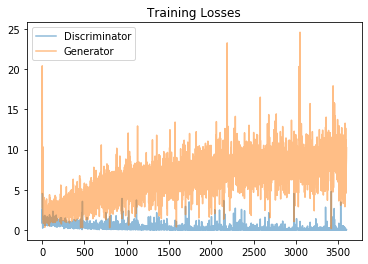

In [109]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()

## Generator samples from training

View samples of images from the generator, and answer a question about the strengths and weaknesses of your trained models.

In [110]:
# helper function for viewing a list of passed in sample images
def view_samples(epoch, samples):
    fig, axes = plt.subplots(figsize=(16,4), nrows=2, ncols=8, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        img = img.detach().cpu().numpy()
        img = np.transpose(img, (1, 2, 0))
        img = ((img + 1)*255 / (2)).astype(np.uint8)
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((32,32,3)))

In [111]:
# Load samples from generator, taken while training
with open('train_samples.pkl', 'rb') as f:
    samples = pkl.load(f)

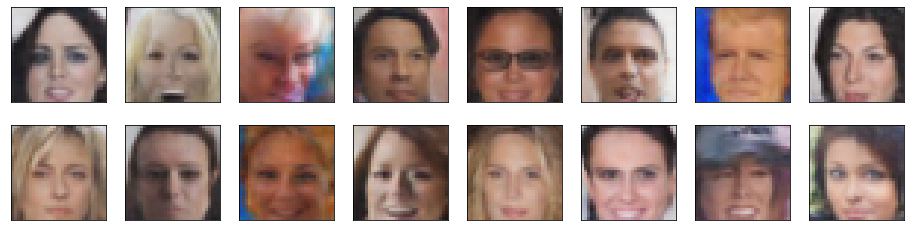

In [112]:
_ = view_samples(-1, samples)

### Question: What do you notice about your generated samples and how might you improve this model?
When you answer this question, consider the following factors:
* The dataset is biased; it is made of "celebrity" faces that are mostly white
* Model size; larger models have the opportunity to learn more features in a data feature space
* Optimization strategy; optimizers and number of epochs affect your final result


**Answer:**

Generated samples aren't too bad. There seems to be some noise in the forehead and eye areas. The skin tone is certainly not diverse, as noted by the first bullet. This is a common problem though with many of the standard datasets used for benchmarking.

For model size, I tried a few different architectures, but found this one trained relatively well within a reasonable amount of time. For this architecure, I didn't include regularization of the discriminator loss function.

Optimization strategy followed the recommendations in the original GAN paper, and I didn't really see any issue with optimization.

A note on the losses: I do believe that this model had a difficult time converging for both the generator and discriminator. The discriminator probably overfit given the limited dataset which I hoped could be fixed with regularization. Turns out, this architecture did better in my opinion.

So I did some research on how to improve GAN convergence and found a paper that also talked about the difficulty of measuring success because there really isn't a good objective function for GANs, and success is often up to the subjectivity of the researcher. So in this case, I think the generated faces aren't too bad, but could definitely be better. But I also don't think the divergence in generator error is too big of an issue either.

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "problem_unittests.py" files in your submission.